In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import mne
import scipy
from mne.datasets.sleep_physionet.age import fetch_data

import epoch

In [2]:
psg_file = "data/SC4001E0-PSG.edf"
psg_data = mne.io.read_raw_edf(psg_file)

Extracting EDF parameters from c:\Tum\5-AR-local\AprendizajeAutomatico\72.75-ML\final\data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
fs = psg_data.info.get('sfreq')
print(fs,'Hz')

data = psg_data.get_data()
data.shape

100.0 Hz


(7, 7950000)

In [4]:
secs = data.shape[1]/fs
print(f'{secs} segundos')
print(f'{secs/60} minutos')
print(f'{secs/60/60} horas\n')


print(f"Channel names = {psg_data.ch_names}\n")
print(f"Channel types = {psg_data.get_channel_types()}")
print(f"Len = {len(psg_data['EEG Fpz-Cz'][0][0])}")

79500.0 segundos
1325.0 minutos
22.083333333333332 horas

Channel names = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']

Channel types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg']
Len = 7950000


In [5]:
len(psg_data['EEG Fpz-Cz'][0][0])
t = psg_data['EEG Fpz-Cz'][1]
t

array([0.000000e+00, 1.000000e-02, 2.000000e-02, ..., 7.949997e+04,
       7.949998e+04, 7.949999e+04])

In [6]:
print(psg_data.info.get('ch_names'))
EEG_Fpz_Cz, EEG_Pz_Oz, EOG_Horizontal, Resp_oro_nasal, EMG_submental, Temp_rectal, Event_marker= data[0], data[1], data[2], data[3], data[4], data[5], data[6]

['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']


In [7]:
#add annotations
hypnogramm_file = "data/SC4001EC-Hypnogram.edf"
hypnogramm_annotations = mne.read_annotations(hypnogramm_file)
psg_data.set_annotations(hypnogramm_annotations)


C:\Users\flo12\AppData\Local\Temp\ipykernel_10440\2458527308.py:4: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  psg_data.set_annotations(hypnogramm_annotations)


<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~13 kB, data not loaded>

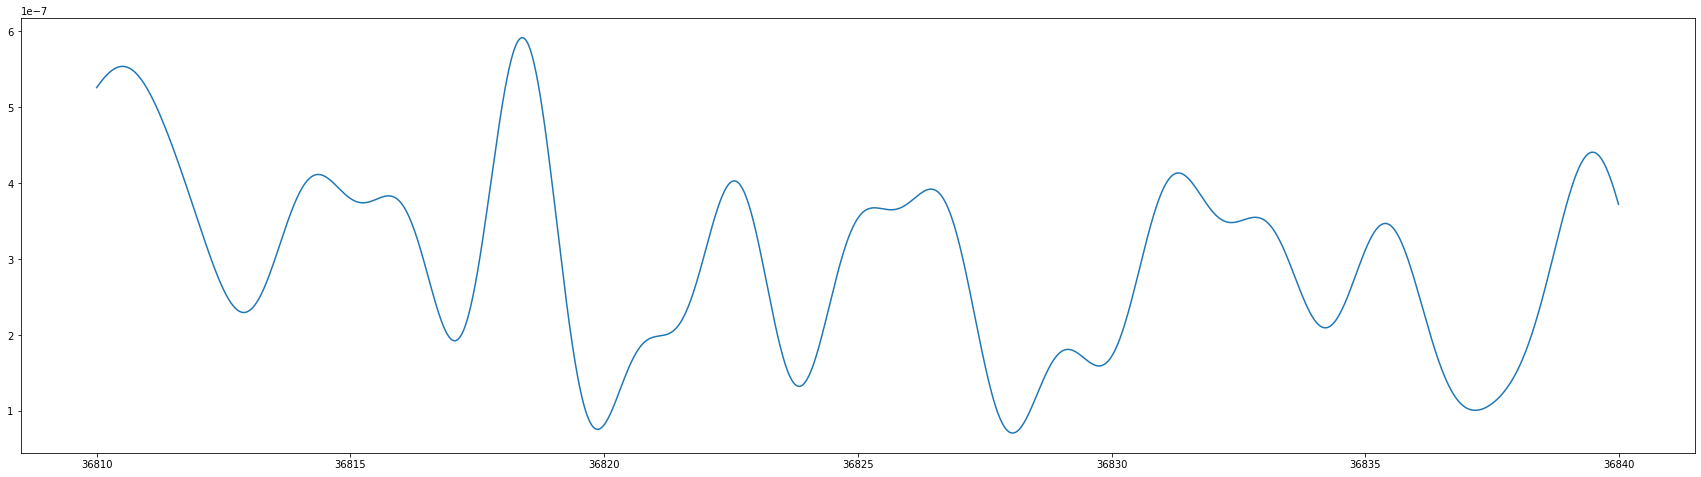

2


In [8]:


EPOCH_LENGTH = 30
epoch = 1227
epoch_start = int(epoch*EPOCH_LENGTH*fs)
epoch_end = int((epoch + 1)*EPOCH_LENGTH*fs)    


# FILTRADO
N = 5 # Orden del filtro
wn = [1,10] # Frecuencias de corte del filtro
sos = scipy.signal.butter(N, wn, btype = 'bandpass', output = 'sos', fs = fs) # Diseño el filtro
filtrada = scipy.signal.sosfiltfilt(sos, EEG_Fpz_Cz) # Filtro la señal


plt.figure(figsize=(30,8))
#plt.plot(t[epoch_start:epoch_end] ,EEG_Fpz_Cz[epoch_start:epoch_end])
plt.plot(t[epoch_start:epoch_end] ,EMG_submental[epoch_start:epoch_end])
plt.show()


start_datetime = psg_data.info['meas_date']
a = psg_data.annotations.copy().crop(
    start_datetime.timestamp() + epoch * EPOCH_LENGTH,
    start_datetime.timestamp() + epoch * EPOCH_LENGTH + EPOCH_LENGTH)
print(len(a))

In [9]:
#load same data from epoch
import epoch
import filters

s = epoch.sleepRecording()
s.init_from_file("data/SC4001E0-PSG.edf","data/SC4001EC-Hypnogram.edf")


Extracting EDF parameters from c:\Tum\5-AR-local\AprendizajeAutomatico\72.75-ML\final\data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\Tum\5-AR-local\AprendizajeAutomatico\72.75-ML\final\epoch.py:117: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  psg_data_raw.set_annotations(hypnogramm_annotations)


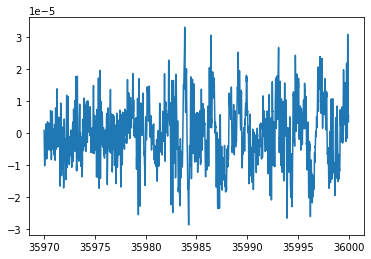

In [10]:
epoch = s.get_epochs_by_label("Sleep stage R")[0]
plt.plot(epoch.data_time ,epoch.get_channle_by_name("EEG Pz-Oz"))
plt.show()

Epoch test

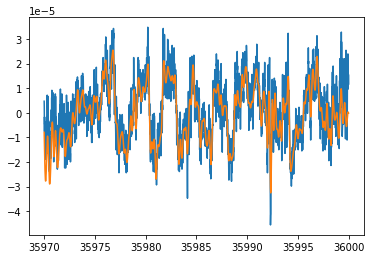

In [11]:
# channles ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
epoch = s.get_epochs_by_label("Sleep stage R")[0]
plt.plot(epoch.data_time ,epoch.get_channle_by_name("EOG horizontal"))
s.apply_filter(filters.bandpass_filter(filters.bandpass_filter.wn_EEG), ["EEG Pz-Oz", "EEG Fpz-Cz"])
s.apply_filter(filters.bandpass_filter(filters.bandpass_filter.wn_EOG), ["EOG horizontal"])
plt.plot(epoch.data_time ,epoch.get_channle_by_name("EOG horizontal"))
plt.show()

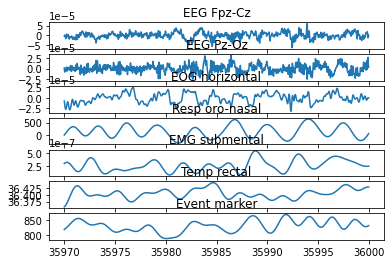

In [12]:
epoch.visualize()

features

In [13]:
from createFeatures import create_features_recording_session
create_features_recording_session(s)

dict_keys(['Sleep stage W', 'Sleep stage 2', 'Sleep stage 1', 'Sleep stage R', 'Sleep stage 3', 'Sleep stage 4'])


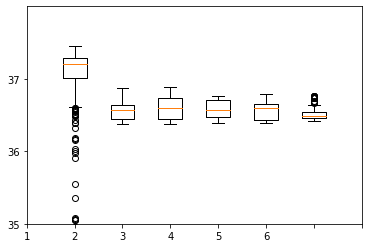

In [21]:
fig, ax = plt.subplots()

data = dict()
for phase in s.sleep_stages:
    data[phase] = []

for epoch in s.epochs:
    data[epoch.label].append(epoch.features["avg_temp"])

# Unpack the data dictionary
unpacked_data = list(data.values())
print(data.keys())

VP = ax.boxplot(unpacked_data, positions=[1, 2, 3, 4 ,5,6])

ax.set(xlim=(0, 1), xticks=np.arange(0, 8),
    ylim=(35, 38), yticks=np.arange(35, 38))

plt.show()

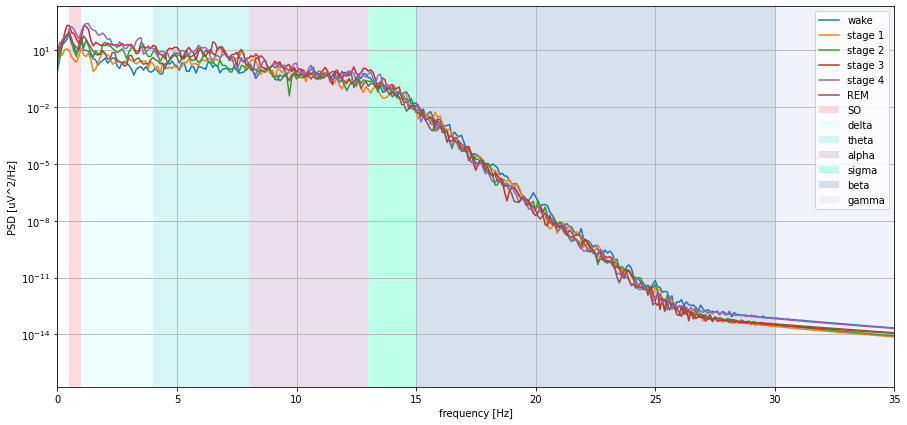

In [32]:
FREQ_BANDS = {'SO':[0.5, 1],
            'delta': [1, 4],
            'theta': [4, 8],
            'alpha': [8, 13],
            'sigma': [13,15],
            'beta': [15, 30],
            'gamma': [30, 60]}

plt.figure(figsize = (15,7))


w_w = s.get_epochs_by_label("Sleep stage W")[0].features['welsh_Pz-Oz']
w_1 = s.get_epochs_by_label("Sleep stage 1")[1].features['welsh_Pz-Oz']
w_2 = s.get_epochs_by_label("Sleep stage 2")[0].features['welsh_Pz-Oz']
w_3 = s.get_epochs_by_label("Sleep stage 3")[0].features['welsh_Pz-Oz']
w_4 = s.get_epochs_by_label("Sleep stage 4")[0].features['welsh_Pz-Oz']
w_R = s.get_epochs_by_label("Sleep stage R")[0].features['welsh_Pz-Oz']
f = s.get_epochs_by_label("Sleep stage W")[0].features['welsh_f']
plt.semilogy(f, w_w, label='wake')
plt.semilogy(f, w_1, label='stage 1')
plt.semilogy(f, w_2, label='stage 2')
plt.semilogy(f, w_3, label='stage 3')
plt.semilogy(f, w_4, label='stage 4')
plt.semilogy(f, w_R, label='REM')

plt.axvspan(FREQ_BANDS['SO'][0],    FREQ_BANDS['SO'][1], facecolor='lightpink', label='SO', alpha=0.5)
plt.axvspan(FREQ_BANDS['delta'][0], FREQ_BANDS['delta'][1], facecolor='lightcyan', label='delta',alpha=0.5)
plt.axvspan(FREQ_BANDS['theta'][0], FREQ_BANDS['theta'][1], facecolor='paleturquoise', label='theta',alpha=0.5)
plt.axvspan(FREQ_BANDS['alpha'][0], FREQ_BANDS['alpha'][1], facecolor='thistle', label='alpha',alpha=0.5)
plt.axvspan(FREQ_BANDS['sigma'][0], FREQ_BANDS['sigma'][1], facecolor='aquamarine', label='sigma',alpha=0.5)
plt.axvspan(FREQ_BANDS['beta'][0],  FREQ_BANDS['beta'][1], facecolor='lightsteelblue', label='beta',alpha=0.5)
plt.axvspan(FREQ_BANDS['gamma'][0], FREQ_BANDS['gamma'][1], facecolor='lavender', label='gamma',alpha=0.5)

plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [uV^2/Hz]')

plt.legend()
plt.xlim([0, 35])
plt.grid()